# Compare to VMC

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ August 15, 2022

Calculating momentum distributions using the low RG resolution method and comparing to VMC data.

_Last update:_ August 15, 2022

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

In [2]:
# Imports from A.T. codes
from scripts.figures import set_rc_parameters, label_lambda, label_nucleus
from scripts.integration import gaussian_quadrature_mesh, momentum_mesh
from scripts.momentum_distributions import MomentumDistribution
from scripts.pmd import Pair
from scripts.snmd import SingleNucleon
from scripts.tools import replace_periods

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/spectroscopic_factors/'

# Directory for VMC data
vmc_directory = '../data/vmc/momentum_distributions/'

## Plotting functions

In [5]:
def generate_momentum_distribution_data(
    kvnn, generator, lamb, kmax=15.0, kmid=3.0, ntot=120, density='Gogny',
    channels=('1S0','3S1')):
    
    q_array, _ = momentum_mesh(kmax, kmid, ntot)
    Q_array, _ = gaussian_quadrature_mesh(2.0, 40)
    
    pmd = Pair(kvnn, kmax, kmid, ntot, channels, generator, lamb)
    
    nucleus_name, Z, N = 'He4', 2, 2
    
    t0 = time.time()
    
    # Compute for Q > 0
    n_pn_array_2D = pmd.compute_momentum_distribution(
        q_array, Q_array, 'pn', nucleus_name, Z, N, density, save=True
    )
    n_pp_array_2D = pmd.compute_momentum_distribution(
        q_array, Q_array, 'pp', nucleus_name, Z, N, density, save=True
    )
    n_nn_array_2D = pmd.compute_momentum_distribution(
        q_array, Q_array, 'nn', nucleus_name, Z, N, density, save=True
    )
    
    # Compute for Q = 0
    n_pn_array_1D = pmd.compute_momentum_distribution_Q0(
        q_array, 'pn', nucleus_name, Z, N, density, save=True
    )
    n_pp_array_1D = pmd.compute_momentum_distribution_Q0(
        q_array, 'pp', nucleus_name, Z, N, density, save=True
    )
    n_nn_array_1D = pmd.compute_momentum_distribution_Q0(
        q_array, 'nn', nucleus_name, Z, N, density, save=True
    )
    
    snmd = SingleNucleon(kvnn, kmax, kmid, ntot, channels, generator, lamb)
    
    n_p_array = snmd.compute_momentum_distribution(
        q_array, 'proton', nucleus_name, Z, N, density, save=True)
    n_n_array = snmd.compute_momentum_distribution(
        q_array, 'neutron', nucleus_name, Z, N, density, save=True)
    
    t1 = time.time()
    mins = (t1-t0)/60.0
    print(f"Done after {mins} minutes.")

In [6]:
# Need data files for the following \lambda values
# generate_momentum_distribution_data(6, 'Wegner', 1.0)
# generate_momentum_distribution_data(6, 'Wegner', 2.0)
# generate_momentum_distribution_data(6, 'Wegner', 3.0)

In [7]:
def compare_he4(
        kvnn, generator, lamb, kmax=15.0, kmid=3.0, ntot=120, density='Gogny',
        channels=('1S0','3S1'), x_limits=(0,5), y_limits=(5e-4,4e5),
        save=False):
    """Compare pair momentum distributions of He4."""
    
    # Set-up relative and CoM momentum arrays
    Q_array = np.arange(0.0, 1.5, 0.25)
    q_array = np.linspace(0.01, 5.0, 500)
    
    # Initialize multi-plot figure
    plt.close('all')
    row_number = 2
    col_number = 3
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number,4*row_number))
    
    # Calculate pair momentum distributions for He4
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    
    # Loop over Q values and add to plot
    for iQ, Q in enumerate(Q_array):
        
        if Q == 0.0:
            
            n_pn_func = md.get_pair_momentum_distribution(
                'pn', 'He4', density, channels, generator, lamb,
                Q_equals_zero=True, interpolate=True
            )
            n_pp_func = md.get_pair_momentum_distribution(
                'pp', 'He4', density, channels, generator, lamb,
                Q_equals_zero=True, interpolate=True
            )
            
            n_pn_array = 2*n_pn_func(q_array)
            n_pp_array = n_pp_func(q_array)
            
        else:
            
            n_pn_func = md.get_pair_momentum_distribution(
                'pn', 'He4', density, channels, generator, lamb,
                interpolate=True
            )
            n_pp_func = md.get_pair_momentum_distribution(
                'pp', 'He4', density, channels, generator, lamb,
                interpolate=True
            )
            
            n_pn_array = 2*n_pn_func(q_array, Q)[:,0]
            n_pp_array = n_pp_func(q_array, Q)[:,0]
        
        # Get row and column number
        if iQ < col_number:
            i, j = 0, iQ
        else:
            i, j = 1, iQ % col_number

        # Set y-axis to log scale
        axs[i,j].set_yscale('log')
        
        axs[i,j].plot(q_array, n_pn_array, color='xkcd:blue', label='pn',
                      linewidth=2.0)
        axs[i,j].plot(q_array, n_pp_array, color='xkcd:red', label='pp',
                      linewidth=2.0)

        # Add VMC data with error bars
        vmc_file_name = replace_periods(f'He4_pair_Q{Q}') + '.txt'
        vmc_data = np.loadtxt(vmc_directory + vmc_file_name)
        q_array_vmc = vmc_data[:, 0]  # fm^-1
        n_pn_array_vmc = vmc_data[:, 1]  # fm^3
        n_pn_errs_array_vmc = vmc_data[:, 2]  # fm^3
        n_pp_array_vmc = vmc_data[:, 3]  # fm^3
        n_pp_errs_array_vmc = vmc_data[:, 4]  # fm^3

        axs[i,j].errorbar(
            q_array_vmc, n_pn_array_vmc, yerr=n_pn_errs_array_vmc,
            color='xkcd:blue', linestyle='', marker='.'
        )
        axs[i,j].errorbar(
            q_array_vmc, n_pp_array_vmc, yerr=n_pp_errs_array_vmc,
            color='xkcd:red', linestyle='', marker='.'
        )

        # Axes limits
        axs[i,j].set_xlim(x_limits)
        axs[i,j].set_ylim(y_limits)

        # Label x-axis on bottom row
        if i == 1:
            axs[i,j].set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=16)
    
        # Label y-axis on left column
        if j == 0:
            axs[i,j].set_ylabel(r"$n(q,Q)$"+" [fm"+r"$^6$"+"]", fontsize=16)
            
        # Add Q label
        Q_label = f'Q={Q} fm' + r'$^{-1}$'
        if i == 0:
            Q_label_location = 'lower right'
        else:
            Q_label_location = 'upper right'
        axs[i,j].add_artist(
            AnchoredText(Q_label, loc=Q_label_location, prop=dict(size=16),
                         frameon=False)
        )
        
    # Add legend
    axs[0,0].legend(loc='upper right', fontsize=16, frameon=False)
    
    # Add \lambda label
    axs[0,1].add_artist(
        AnchoredText(label_lambda(lamb, generator), loc='upper right',
                     prop=dict(size=16), frameon=False)
    )
        
    # Add nucleus label
    axs[0,2].add_artist(
        AnchoredText(label_nucleus('He4'), loc='upper right',
                     prop=dict(size=20), frameon=False)
    )
    
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.05, wspace=0.05)

    # Save file
    if save:
        file_name = f'compare_he4_kvnn_{kvnn}_{generator}_{lamb}_{density}'
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

In [8]:
def proton_momentum_distribution(
        kvnn, generator, lamb, kmax=15.0, kmid=3.0, ntot=120, density='Gogny',
        channels=('1S0','3S1'), x_limits=(0,5), y_limits=(4e-4,3e2),
        save=False):
    """Compare proton momentum distributions of He4."""
    
    # --- Figure set-up --- #
    plt.close('all')
    f, ax = plt.subplots(figsize=(4,4))
    
    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # --- Get data --- #
    # Unpack nucleus information
    nucleus_name, Z, N = 'He4', 2, 2
    
    # Initialize momentum distribution object
    md = MomentumDistribution(kvnn, kmax, kmid, ntot)
    
    q_array, n_p_array = md.get_single_nucleon_momentum_distribution(
        'proton', nucleus_name, density, channels, generator, lamb
    )

    # Plot
    ax.plot(q_array, n_p_array/Z, color='xkcd:red',
            label=label_nucleus(nucleus_name), linewidth=2.0)

    # Add VMC data with error bars
    vmc_data = np.loadtxt(vmc_directory + 'He4_single_nucleon.txt')
    q_array_vmc = vmc_data[:, 0] # fm^-1
    n_p_array_vmc = vmc_data[:, 1]
    error_bars_array_vmc = vmc_data[:, 2]
    ax.errorbar(q_array_vmc, n_p_array_vmc/Z, yerr=error_bars_array_vmc/Z,
                color='xkcd:black', label='VMC', linestyle='', marker='.')

    # Axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Axes labels
    ax.set_xlabel("$q$ [fm" + r"$^{-1}$" + "]", fontsize=16)
    ax.set_ylabel("proton "+r"$n(q)/Z$"+" [fm"+r"$^3$"+"]",
                  fontsize=16)
    
    # Legend
    ax.legend(loc='upper right', fontsize=16, frameon=False)
    
    # Add \lambda label
    ax.add_artist(
        AnchoredText(label_lambda(lamb, generator), loc='lower left',
                     prop=dict(size=16), frameon=False)
    )
    
    # Save file
    if save:
        file_name = (f'proton_momentum_distribution_{nucleus_name}_kvnn'
                     f'_{kvnn}')
        for ichannel in channels:
            file_name += f'_{ichannel}'
        file_name += (f'_kmax_{kmax}_kmid_{kmid}_ntot_{ntot}_{generator}_lamb'
                      f'_{lamb}_{density}')
        file_name = replace_periods(file_name) + '.png'
        f.savefig(figures_directory + file_name)

## Compare $^{4}$He pair momentum distributions with VMC

Here we use AV18 SRG-evolved to $\lambda=1.35\,$fm$^{-1}$ under Wegner evolution. We use the Gogny functional and take only S-wave contributions in the evolved operator.

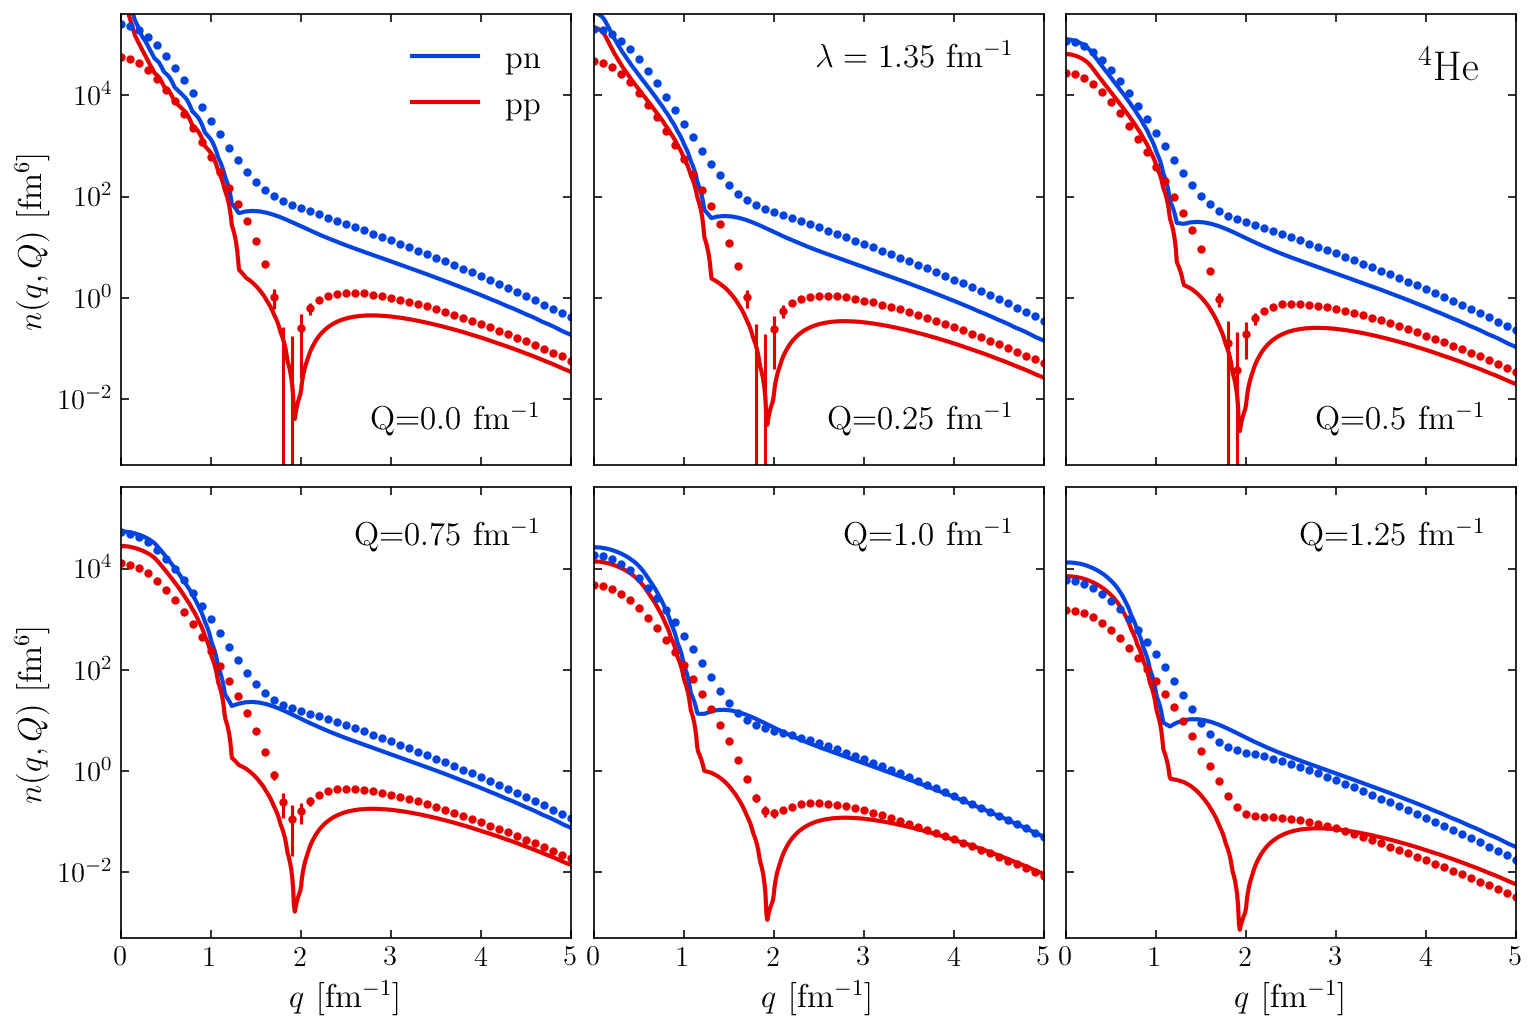

In [9]:
compare_he4(6, 'Wegner', 1.35)

Varying $\lambda$ in the plots below.

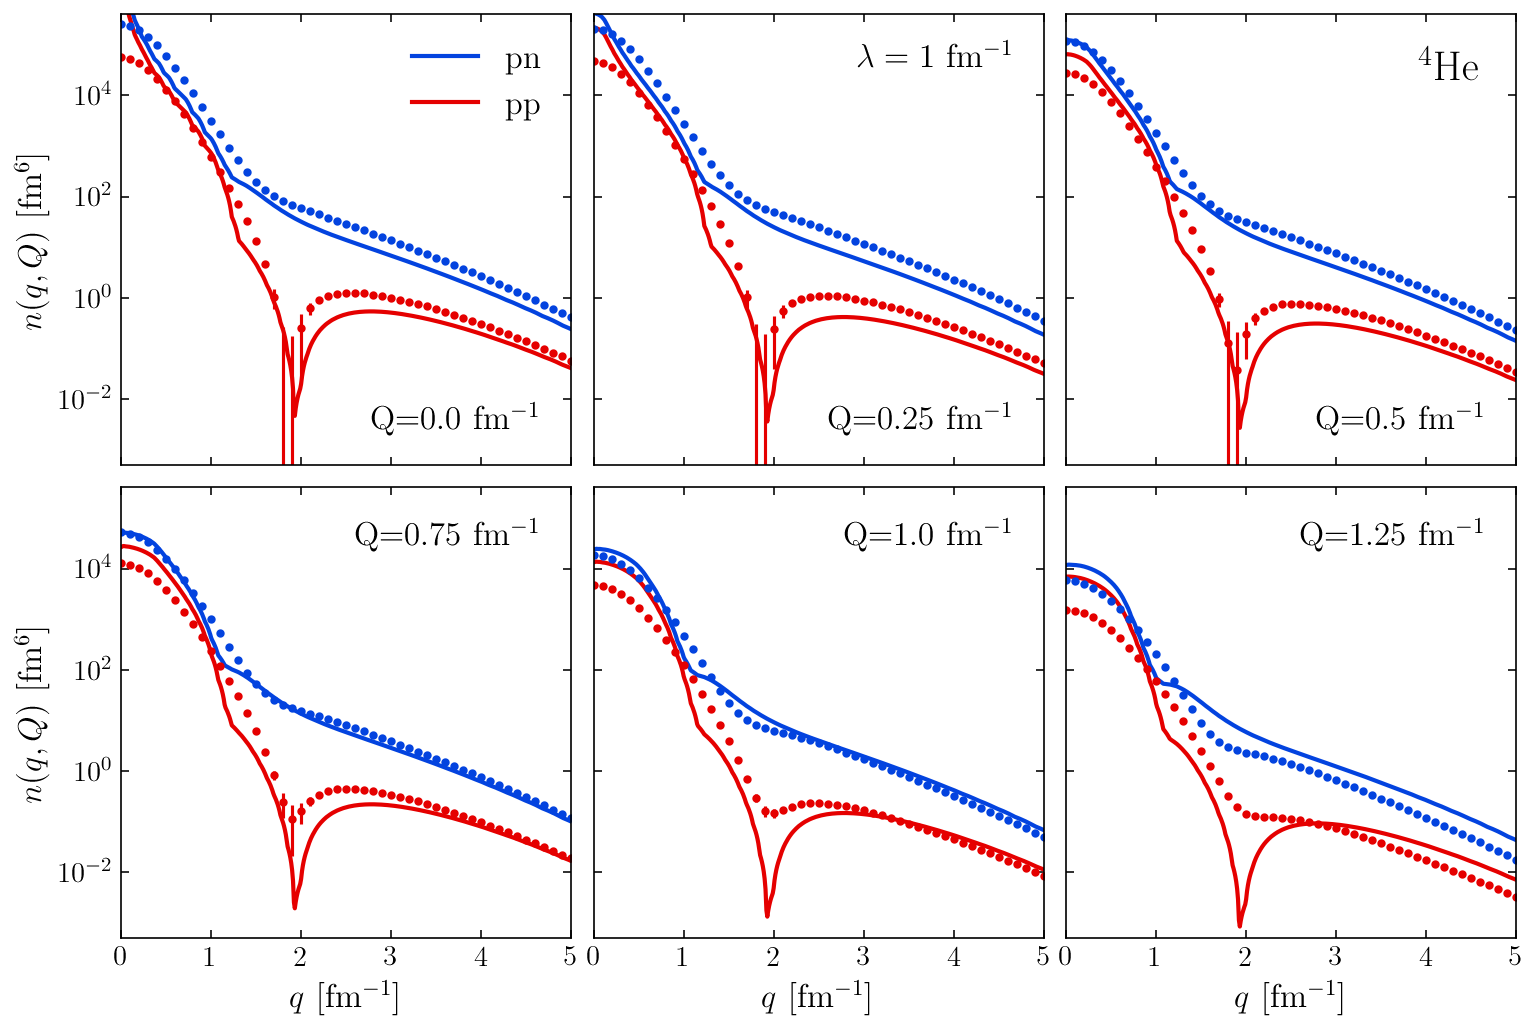

In [10]:
compare_he4(6, 'Wegner', 1.0)

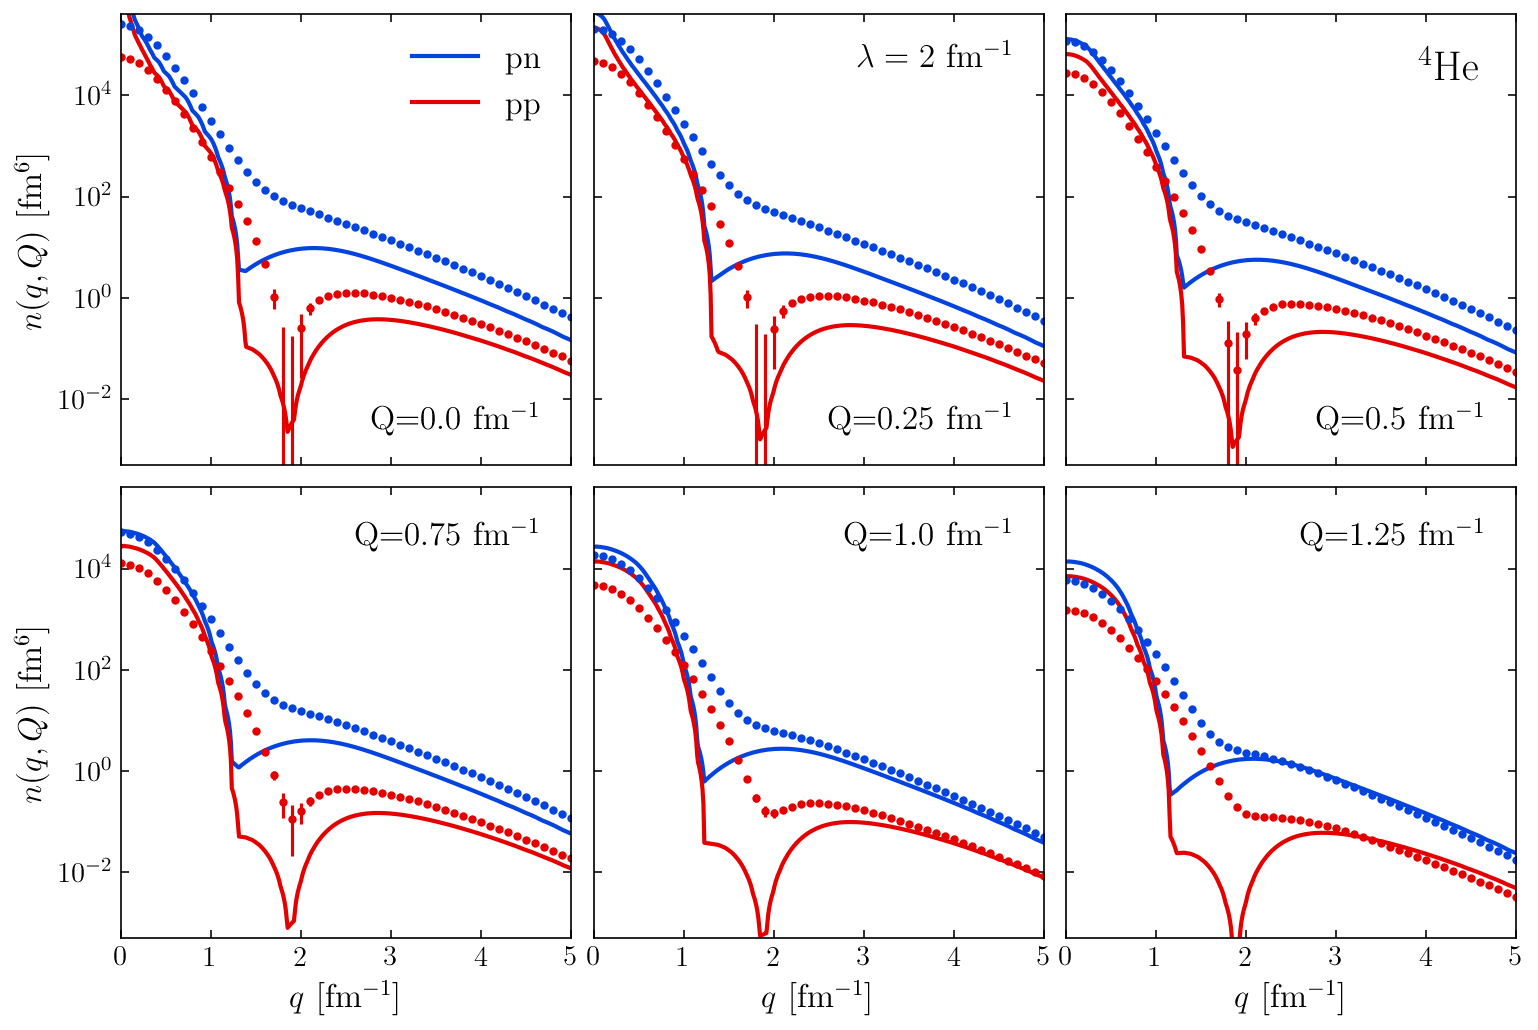

In [11]:
compare_he4(6, 'Wegner', 2.0)

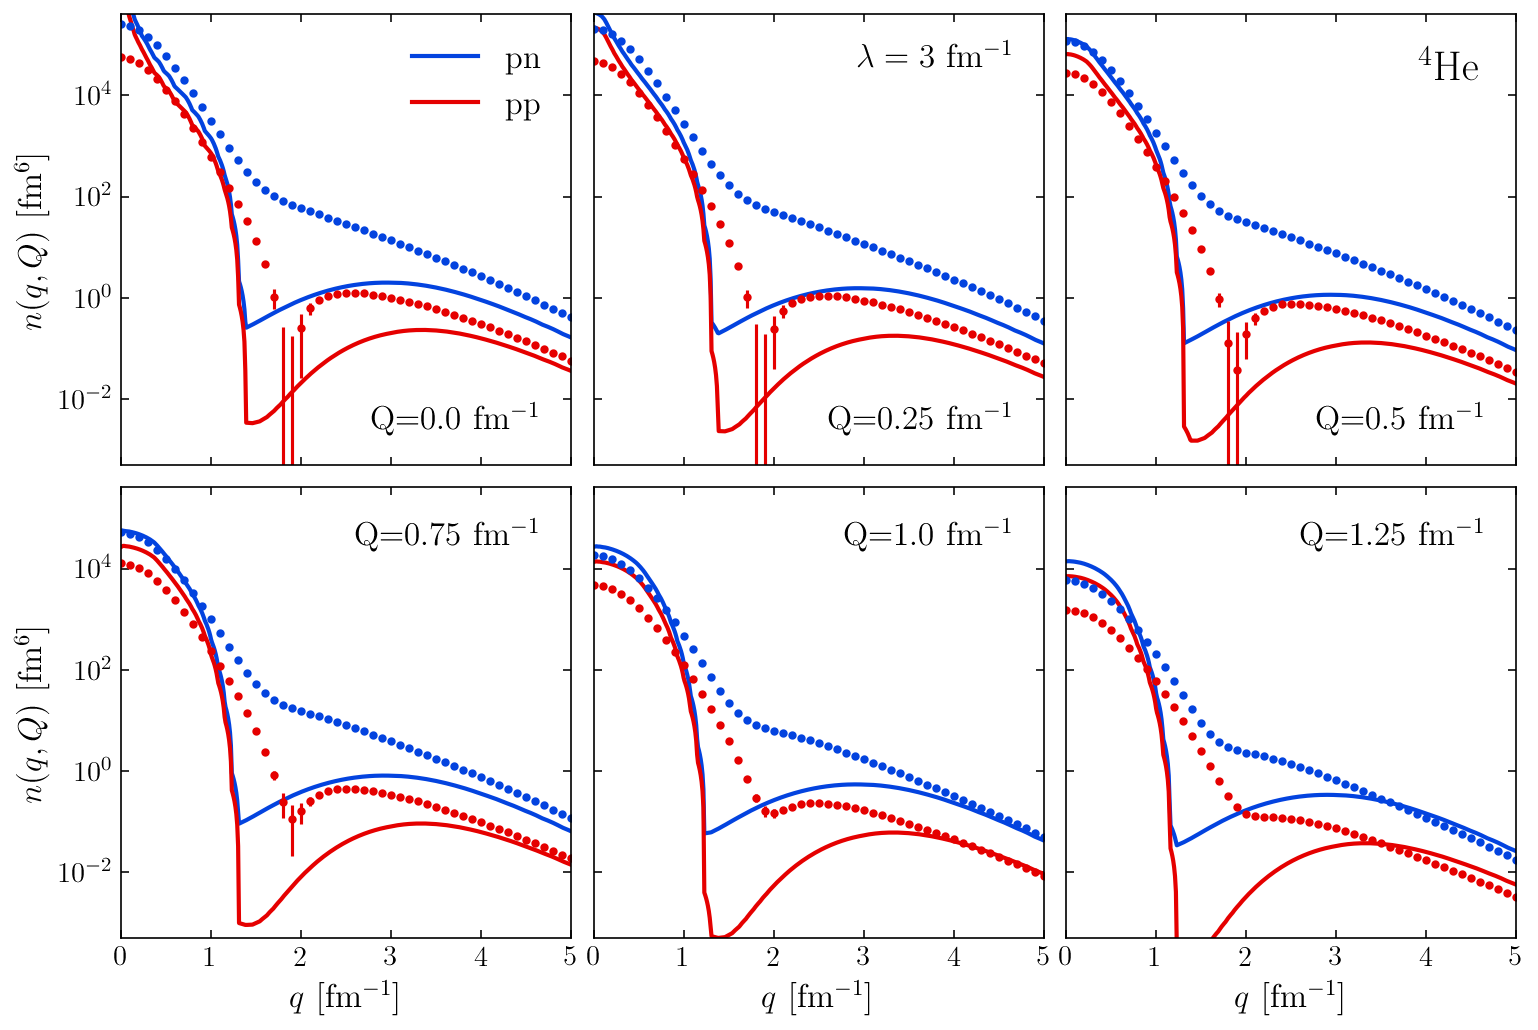

In [12]:
compare_he4(6, 'Wegner', 3.0)

_Notes_:
* Agreement is not as good as the single-nucleon comparison.
* Check normalization and compare to VMC normalization.
* Compare with Q integrated out?
* Other nuclei?

## Compare $^{4}$He single-nucleon momentum distributions with VMC

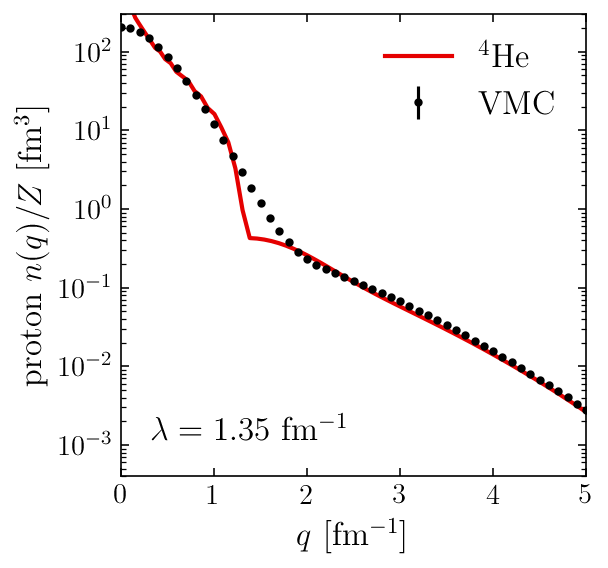

In [13]:
proton_momentum_distribution(6, 'Wegner', 1.35)